In [1]:
from IPython.display import Image 
from PIL import Image
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations as A 
import albumentations.pytorch 
from albumentations.pytorch  import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
import cv2
import numpy as np
import os 

import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters


In [2]:
class ImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        super(ImageFolder,self).__init__() 
        self.data = []
        self.root_dir = root_dir
        self.transform = transform
        self.class_names= os.listdir(root_dir)

        for index, name in enumerate(self.class_names):
            files = os.listdir(os.path.join(root_dir,name))
            self.data += list(zip(files, [index]*len(files)))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img_file , label = self.data[index]
        root_and_dir = os.path.join(self.root_dir,self.class_names[label])
        # added .convert('RGB') to deal with diiferent channels black is 1 , if not get an error about different dimensions 
        image = np.array(Image.open(os.path.join(root_and_dir,img_file)).convert('RGB'))

        if self.transform is not None:
            augmentations= self.transform(image=image)
            image = augmentations['image']

        return image, label

transform = A.Compose(
    [
        A.Resize(250,250),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.6),
        A.Rotate(limit=40,p=0.9),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25,b_shift_limit=25,p=0.8),
        A.Normalize(
            mean=(0,0,0),
            std =(1,1,1),
            max_pixel_value=225,
        p=1),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5)
        ],p=1.0),
        
        ToTensorV2(),
    ]
)


In [3]:
dataset = ImageFolder(root_dir= 'practice',transform=transform)

In [61]:
'''
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_set = dataset
train_loader = DataLoader(dataset=train_set, batch_size=64, shuffle=True)

def get_mean_std(loader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for data, _ in tqdm(loader):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std


mean, std = get_mean_std(train_loader)
print(mean)
print(std)
'''

  0%|          | 0/16 [00:00<?, ?it/s]C:\Users\Invitado\anaconda3\lib\site-packages\PIL\Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 16/16 [00:33<00:00,  2.07s/it]


tensor([0.5826, 0.5446, 0.4943])
tensor([0.3289, 0.3212, 0.3140])


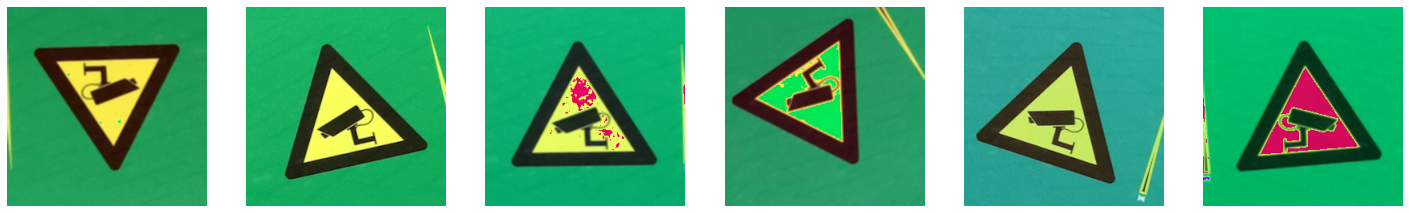

In [13]:
num_samples = 6
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  
  ax[i].imshow(transforms.ToPILImage()(dataset[590][0]))
  ax[i].axis('off')

In [ ]:
#https://www.youtube.com/watch?v=rAdLwKJBvPM
#https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8
#https://towardsdatascience.com/beginners-guide-to-loading-image-data-with-pytorch-289c60b7afec

#How to augment data on the fly
#https://towardsdatascience.com/data-augmentation-and-handling-huge-datasets-with-keras-a-simple-way-240481069376

In [ ]:
# save augmented data as array type tensor in a list
num_samples = 6
dataset_augmented = []
for i in range(len(dataset)):
  for j in range(num_samples):
    dataset_augmented.append(dataset[i])

In [41]:
len(dataset_augmented)

6120

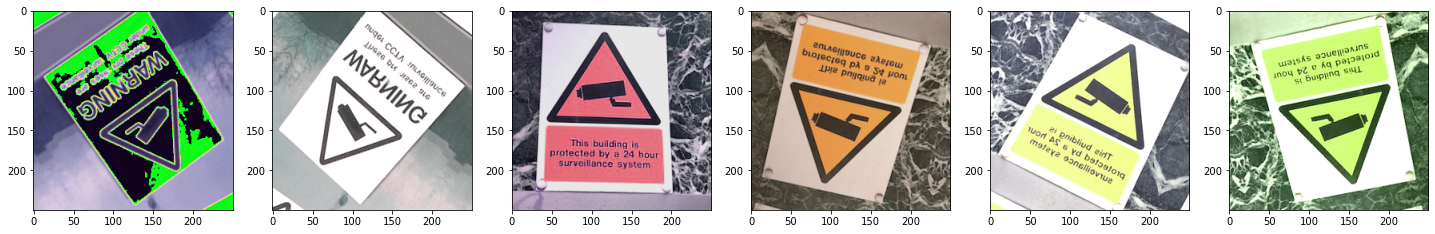

In [54]:
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i,y in enumerate(dataset_augmented[544:550]):
  ax[i].imshow(transforms.ToPILImage()(y[0]))
  

In [46]:
#dataset = ImageFolder(root_dir= 'practice',transform=transform)
pytorch_dataloader = DataLoader(dataset=dataset_augmented, batch_size=64, shuffle=True)
pytorch_dataloader1 = DataLoader(dataset=dataset, batch_size=64, shuffle=True)


In [43]:

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, y  in dl:
        print(len(images))
        show_images(images, nmax)
        break       


64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


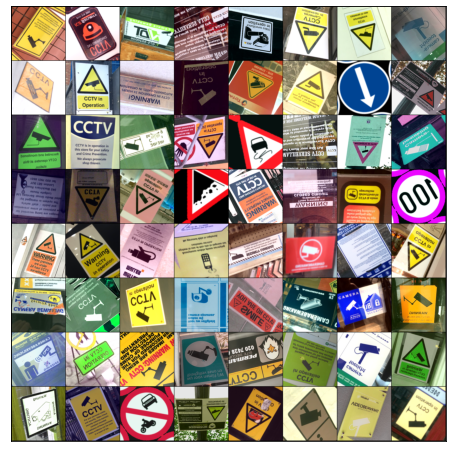

In [44]:
show_batch(pytorch_dataloader)

In [49]:
len(pytorch_dataloader1)
  

16

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 32
num_epochs = 5

train_set, test_set = torch.utils.data.random_split(dataset_augmented, [6000,120])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

# Model
model = torchvision.models.googlenet(pretrained=True)
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

    print(f"Cost at epoch {epoch} is {sum(losses)/len(losses)}")

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()


print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)